# Supervised Learning Classification Project: AllLife Bank Personal Loan Campaign

## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1]:
# Dataframes
import pandas as pd
import numpy as np

# Charting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Warning to ignore in charts
import warnings
warnings.filterwarnings("ignore")

#Scikit-Learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree

# Grid Search
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)


## Constants


In [2]:
TREAT_CONTINUOUS_DATA= False

## Function Definitions
Functions are taken from the low code notebook with a slight modifications when needed.

In [3]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [4]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()

    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="bright",
        order=data[feature].value_counts().index[:n], #.sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [5]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [6]:
### function to plot distributions wrt target
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [7]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth

    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
##  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

## Loading the dataset

In [9]:
##import Google Drive
#from google.colab import drive
#drive.mount('/content/drive/')

In [10]:
#load the dataframe with data from the loan modelling data set.
plcData = pd.read_csv("https://raw.githubusercontent.com/todd-wilson/portfolio/main/personal-loan-campaign/data/loan-modelling.csv")

## Data Overview

### Schema Preview

In [11]:
#Preview the first few rows of data
display(plcData.head(10))

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


#### Observations
* Data appears to be all numerical.
* Education and Experience may need to be treated to allow to ML techniques such as one-hot encoding for the Decision Tree.

### Shape of Data

In [12]:
#Look at the shape of the data
plcData.shape

(5000, 14)

#### Observations
* There are 5000 columns and 14 rows.

### Column Metadata

In [13]:
plcData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


#### Observations
* The data is all numeric with no null values.
* Categories could still be represented as unknown by other means such as -1 so that will need to be looked at later.

### Unique Values

In [14]:
# Look through all the columns to get the unique values.
for col in plcData.columns:
  print(f'{col}: ', plcData[col].unique())

ID:  [   1    2    3 ... 4998 4999 5000]
Age:  [25 45 39 35 37 53 50 34 65 29 48 59 67 60 38 42 46 55 56 57 44 36 43 40
 30 31 51 32 61 41 28 49 47 62 58 54 33 27 66 24 52 26 64 63 23]
Experience:  [ 1 19 15  9  8 13 27 24 10 39  5 23 32 41 30 14 18 21 28 31 11 16 20 35
  6 25  7 12 26 37 17  2 36 29  3 22 -1 34  0 38 40 33  4 -2 42 -3 43]
Income:  [ 49  34  11 100  45  29  72  22  81 180 105 114  40 112 130 193  21  25
  63  62  43 152  83 158  48 119  35  41  18  50 121  71 141  80  84  60
 132 104  52 194   8 131 190  44 139  93 188  39 125  32  20 115  69  85
 135  12 133  19  82 109  42  78  51 113 118  64 161  94  15  74  30  38
   9  92  61  73  70 149  98 128  31  58  54 124 163  24  79 134  23  13
 138 171 168  65  10 148 159 169 144 165  59  68  91 172  55 155  53  89
  28  75 170 120  99 111  33 129 122 150 195 110 101 191 140 153 173 174
  90 179 145 200 183 182  88 160 205 164  14 175 103 108 185 204 154 102
 192 202 162 142  95 184 181 143 123 178 198 201 203 189 151 199 

#### Observations
* Experience has values of -1, -2 and -3. It is not possible to have negative experience so these value will be changed to zero.

In [15]:
# Filter data set on only negative values for experience.
filterExp = plcData[plcData.Experience.isin([-1, -2, -3])]
filterExp.head(5)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,90,25,-1,113,94303,4,2.30,3,0,0,0,0,0,1
226,227,24,-1,39,94085,2,1.70,2,0,0,0,0,0,0
315,316,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0
451,452,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
524,525,24,-1,75,93014,4,0.20,1,0,0,0,0,1,0


### Observations
* Negative experience does not appear to follow any pattern with age or education.

### Negative Value for Experience

In [16]:
# Data set with only negative values for experience. Zero index represents the number of rows.
filterExp.shape[0]

52

#### Observations
* There are 52 rows which have negative experience.

### Statistical Summary

In [17]:
### Statistical Summary of Data
plcData.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


#### Observations
* Family size is ambiguous. Does 4 mean a spouse and 3 children or the customer, spouse and 2 children...
* The lowest age is 23. This may be by design as older borrowers are usually more responsible.

### Data Overview Observations

* There are 14 columns and 5000 rows.
* Data is all numeric, and as a result, cannot contain null values.
* 52 rows show negative working experience.
  * These values will need to be imputed to zero as one cannot have negative experience.
* The family size number is not clear as to what makes up a family. A spouse? Is the customer included in this number? I would also assume there would be families larger than four.
* One-hot Encoding Candidates
  * Income could be broken down into categories such as low income, medium income and high income. >0, >51k >101k and >151k+
    * Order needs to be maintained.
  * Experience could also be broken down into >0, >11 , >21 and >31 years of experience.
    * Order needs to be maintained.
  * Education is probably not a good candidate because there are three distinct categories ordered by educational experience which the decision tree should be able to rank accordingly.
* Rescaling is not required for a Decision Tree as decision trees are not sensitive to variance in the data.

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Univariate Analysis

#### ID

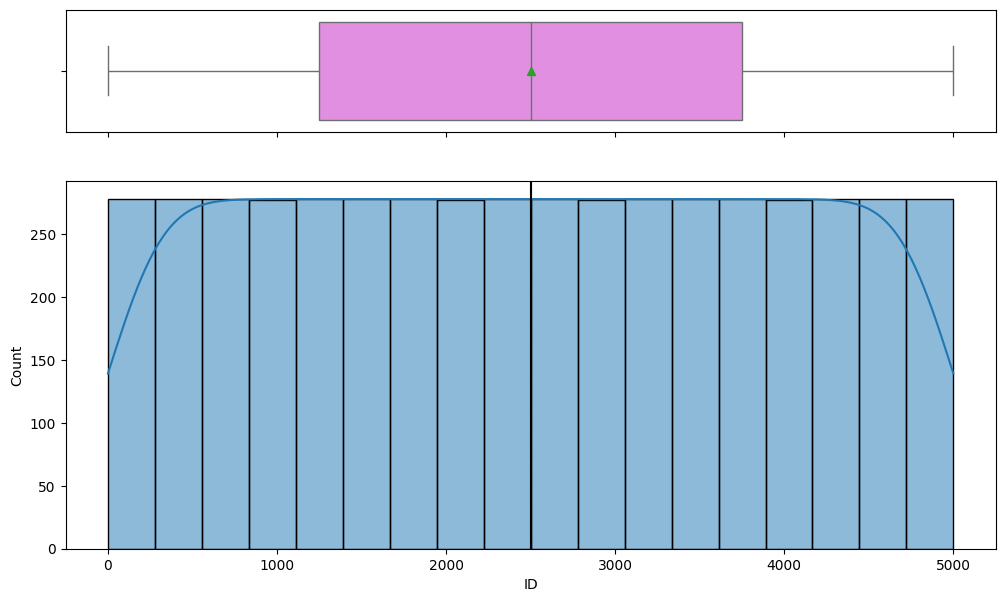

In [18]:
histogram_boxplot(plcData, "ID", kde=True)

##### Observations
* Normal distribution as would be expected from a unique id.

#### Age

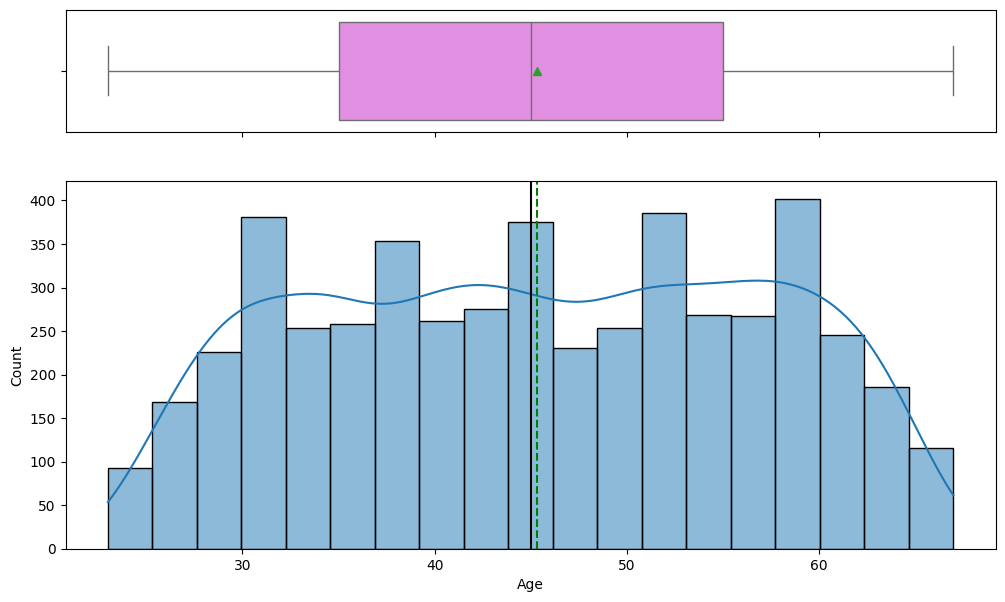

In [19]:
histogram_boxplot(plcData, "Age", kde=True)

##### Observations
* Right skew is negligible.
* Distribution between 30 and 60 is fairly uniform.

#### Experience

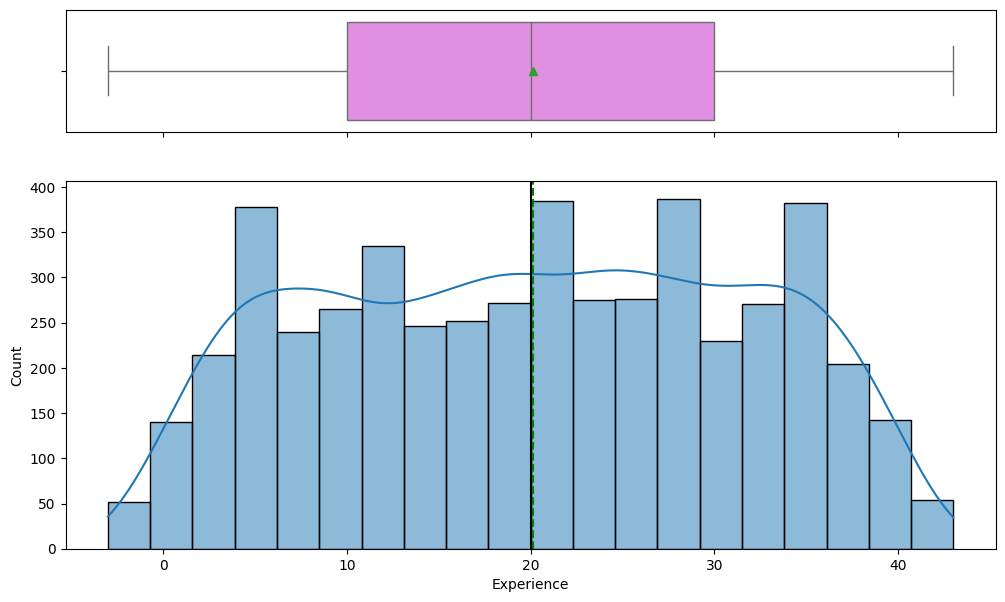

In [20]:
histogram_boxplot(plcData, "Experience", kde=True)

##### Observations
* Almost no skew.
* Distribution between 5 and 35 years is fairly uniform.

#### Income

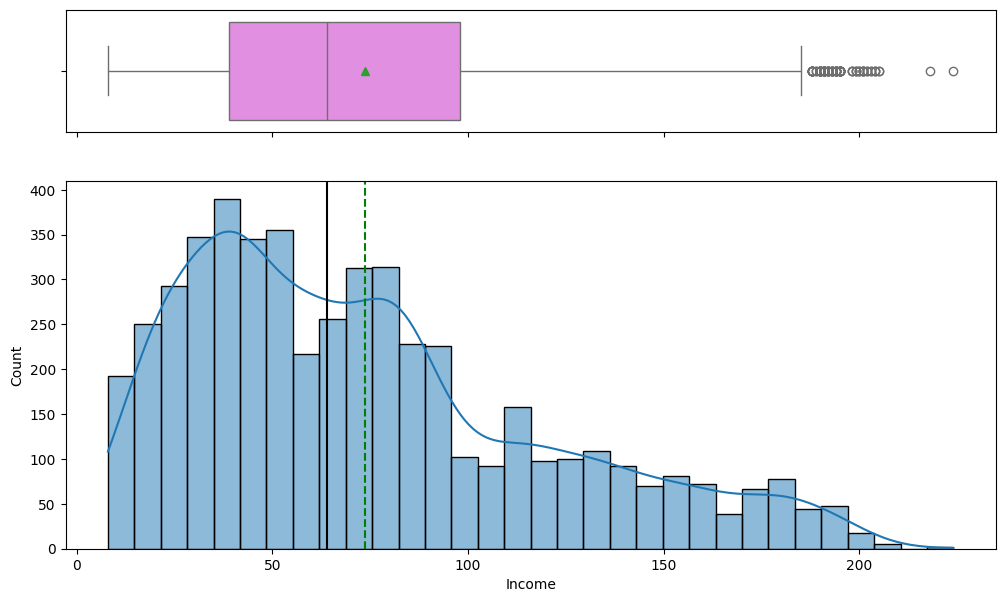

In [21]:
histogram_boxplot(plcData, "Income", kde=True)

##### Observations
* Data is right skewed with most individuals making below $75,000.

#### 	ZIPCode

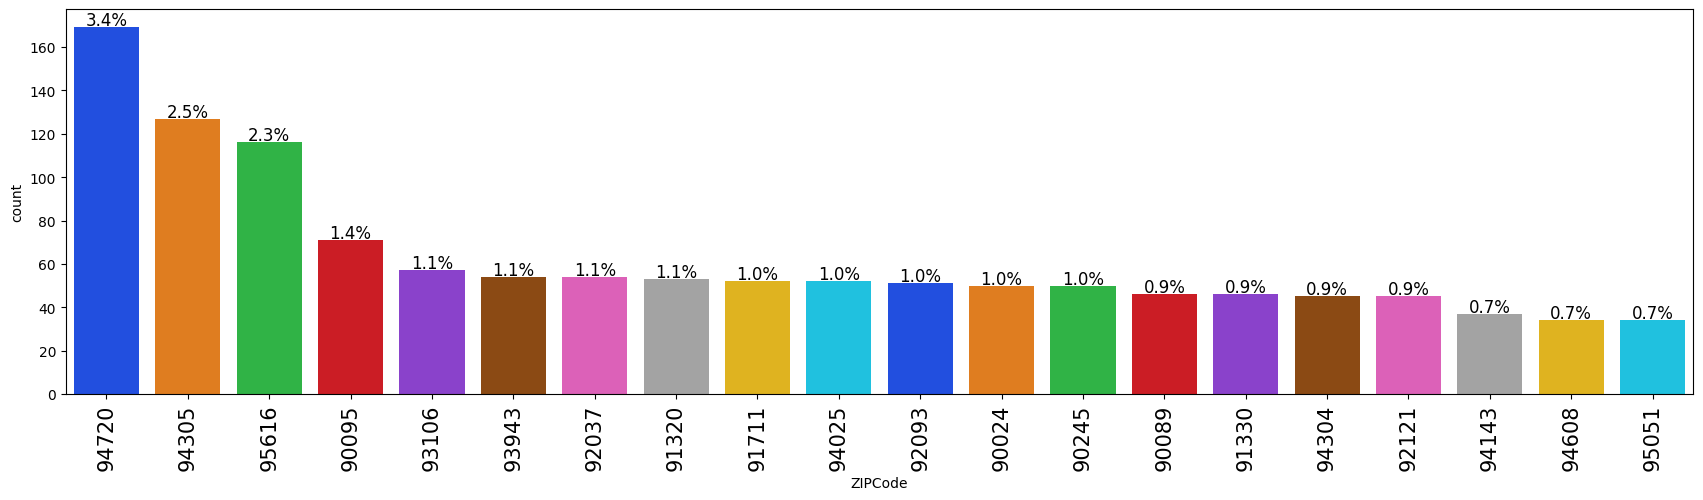

In [22]:
labeled_barplot(plcData, "ZIPCode", perc=True, n=20)

##### Observations
* Most customers are from the 94720 zip code. I don't think this is telling of anything unless income is linked with zip code, but then I think we can use income alone in the decision tree.

#### Family

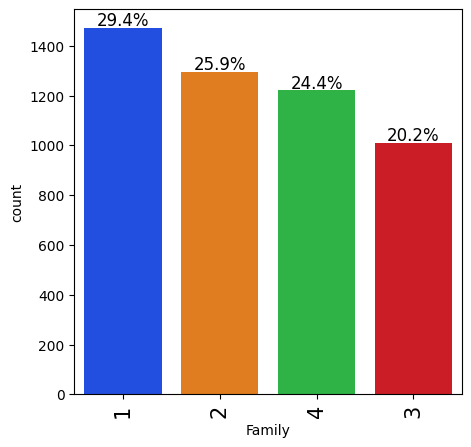

In [23]:
labeled_barplot(plcData, "Family", perc=True)

##### Observations
* Most customer have a family size of 1 then 2 then 4 with a 3-person family being the least represented in the sample. It would make more sense that the 4-person family is the least represented. A 4-person family may have more liabilities and more analysis would be needed to look at income of 4 versus 3-person families.

#### CCAvg

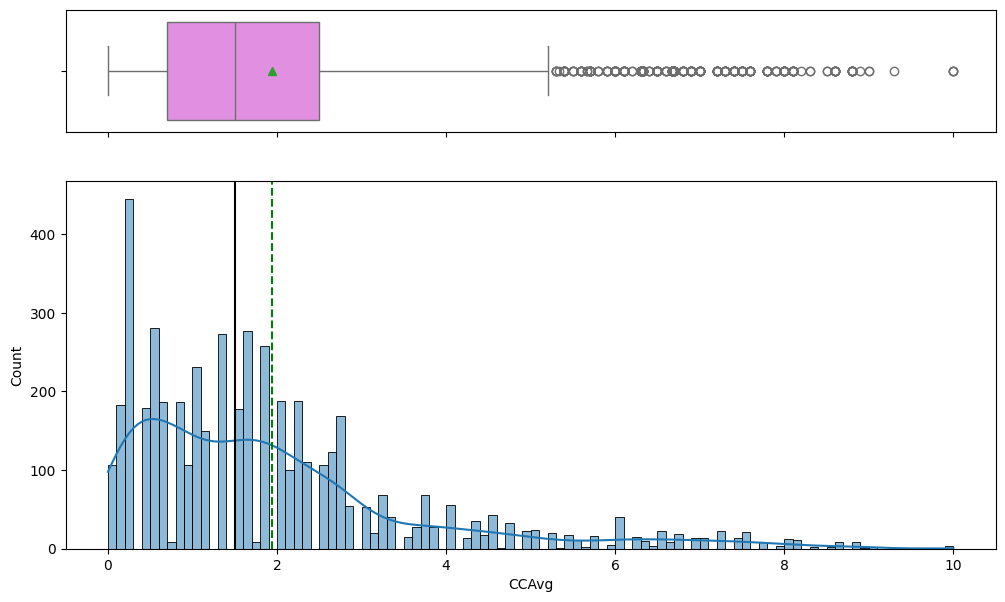

In [24]:
histogram_boxplot(plcData, "CCAvg", kde=True, bins=100);

##### Observations
* Data is skewed to the right.
* Roughly half of customers have a credit card avarage under $1,500 per month.
* Many outliers, but decision trees are not sensitive to outliers so we will not treat them.

#### Education

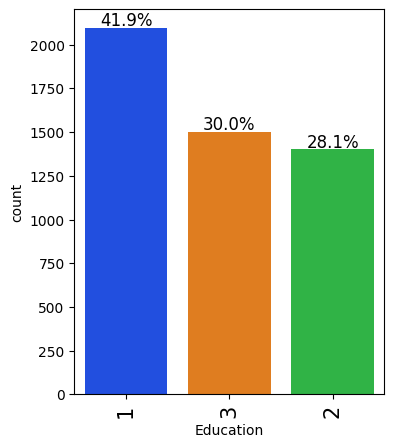

In [25]:
labeled_barplot(plcData, "Education", perc=True)

##### Observations
|Education Level||
|-|-|
|1|Undergrad|
|2|Graduate|
|3|Advanced/Professional|

* Most customers are undergraduates and then Advanced/Professionals.
* Less people have achieved Graduate status which makes sense.

#### 	Mortgage

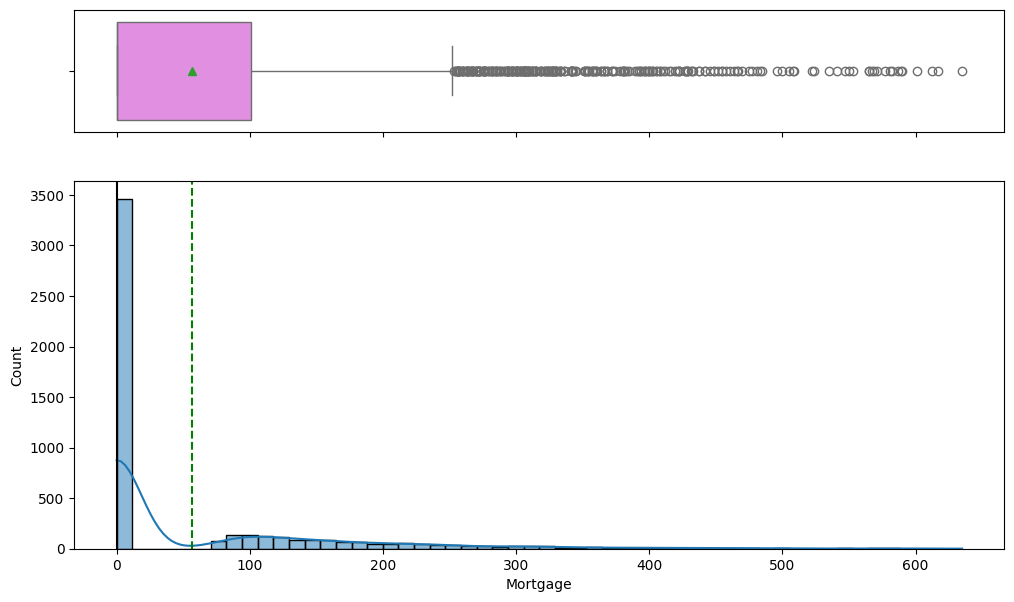

In [26]:
histogram_boxplot(plcData, "Mortgage", kde=True)

In [27]:
# Customers without a mortgage
filterMortgage = plcData["Mortgage"][plcData.Mortgage == 0]
print(filterMortgage.shape[0])
print((filterMortgage.shape[0]/plcData.shape[0]) * 100)

3462
69.24


##### Observations
* 3462 customers do not have a mortgage which represents 69% of customers in the data.

#### Personal_Loan

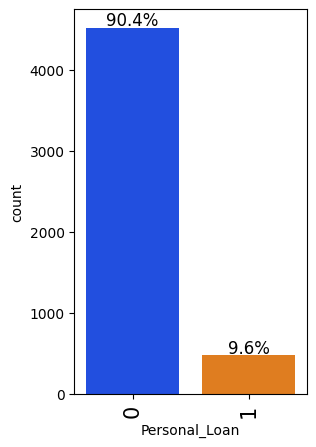

In [28]:
labeled_barplot(plcData, "Personal_Loan", perc=True)

##### Observations
1 = Yes
0 = No

* 9.6% of customers accepted the personal loan offered in the last campaign. The state of the loan is not given nor the loan amount.

#### 	Securities_Account

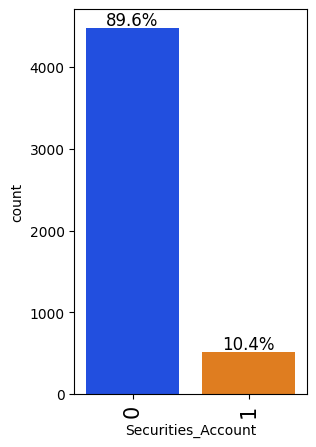

In [29]:
labeled_barplot(plcData, "Securities_Account", perc=True)

##### Observations
1 = Yes
0 = No

* 10.4% of customers have a securities account with the bank.

#### 	CD_Account

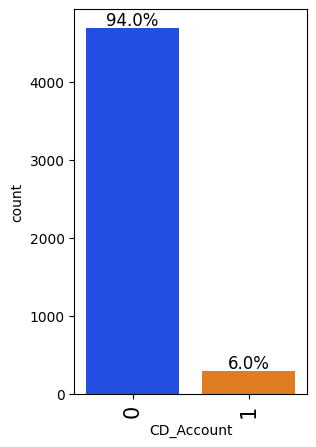

In [30]:
labeled_barplot(plcData, "CD_Account", perc=True)

##### Observations
1 = Yes
0 = No

* 6.0% of customers have a Certificate of Deposit with the bank.

#### Online

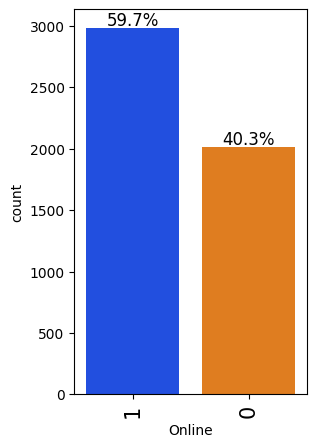

In [31]:
labeled_barplot(plcData, "Online", perc=True)

##### Observations
1 = Yes
0 = No

* Almost 60% of customers use the internet to do banking.

#### CreditCard

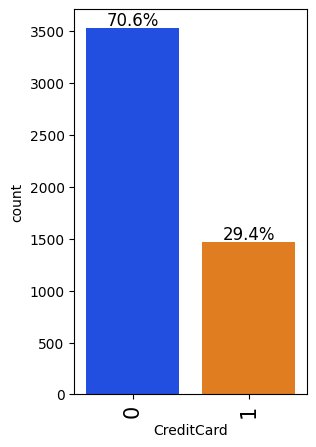

Total number of customers with credit cards from other banks: 1470


In [32]:
labeled_barplot(plcData, "CreditCard", perc=True)
total_customers_with_other_cards = plcData['CreditCard'].sum()

print(f'Total number of customers with credit cards from other banks: {total_customers_with_other_cards}')

##### Observations
* 29.4% of customers have credit cards with other banks.
* That represents 1,470 customers.

### Bivariate Analysis

#### General Heatmap

<Axes: >

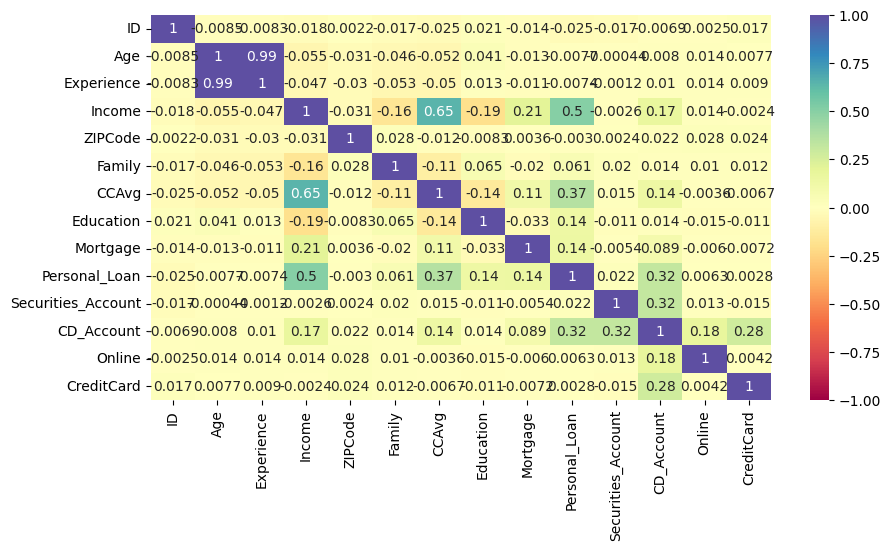

In [33]:
### General Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(plcData.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)

##### Observations
* Very high positive correlation
 * Experience and Age
* High positive correlation
  * Income and CCAvg
* Positive correlations
  * Income and loan acceptance
  * CCAvg and loan acceptance
  * CD Account and loan acceptance
  * CD Account and securities account
  * CD Account and credit card
* Slight positive correlation between...
  * Income and Mortgage
  * Income and CD Account
  * CD Account and online account
* Slight negative correlations between.
  * Education and Income
  * Family and Income
  * Education and CCAvg
  * Family and CCAvg

#### Personal_Loan and Education

Personal_Loan     0    1   All
Education                     
All            4520  480  5000
3              1296  205  1501
2              1221  182  1403
1              2003   93  2096
------------------------------------------------------------------------------------------------------------------------


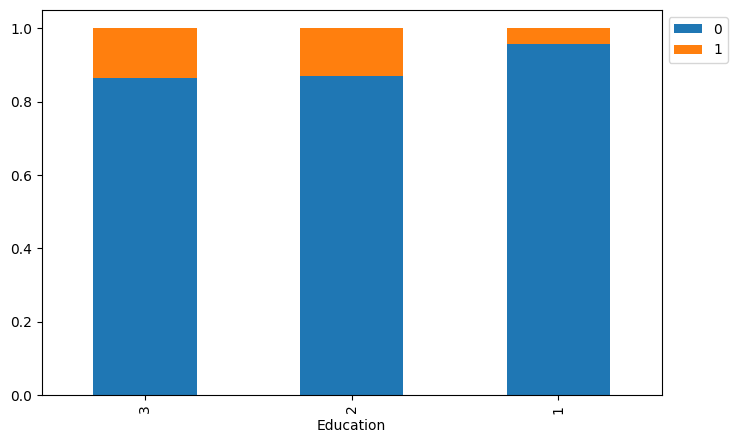

In [34]:
stacked_barplot(plcData,"Education", "Personal_Loan")

##### Observations
|Education Level||
|-|-|
|1|Undergrad|
|2|Graduate|
|3|Advanced/Professional|

* The more educated one is the more likely they are to accept a personal loan with "Advanced/Professionals" leading.

#### Personal_Loan and Family

Personal_Loan     0    1   All
Family                        
All            4520  480  5000
4              1088  134  1222
3               877  133  1010
1              1365  107  1472
2              1190  106  1296
------------------------------------------------------------------------------------------------------------------------


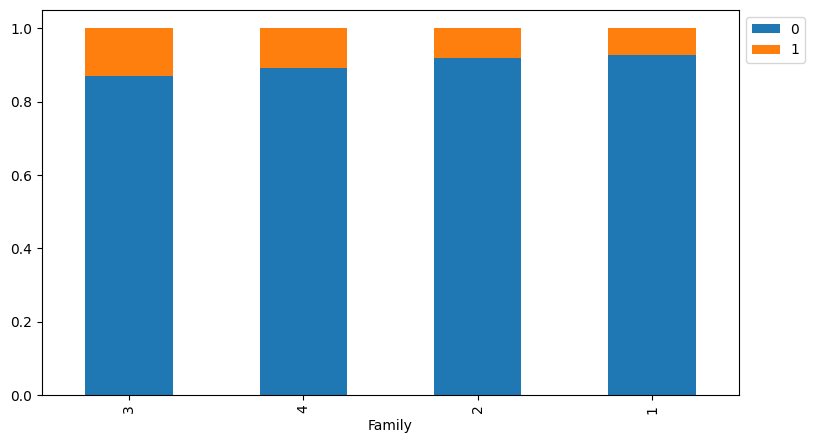

In [35]:
stacked_barplot(plcData,"Family", "Personal_Loan")

##### Observations
* In general, as family size decreases the less likely a customer would be to take a loan.

#### Personal_Loan and Securities Account

Personal_Loan          0    1   All
Securities_Account                 
All                 4520  480  5000
0                   4058  420  4478
1                    462   60   522
------------------------------------------------------------------------------------------------------------------------


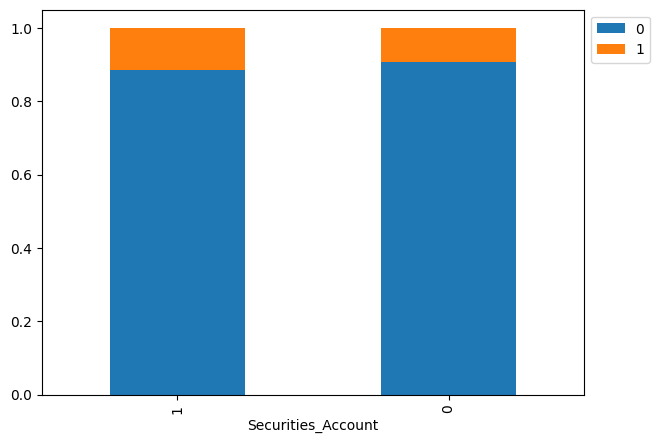

In [36]:
stacked_barplot(plcData,"Securities_Account", "Personal_Loan")

##### Observations
* Customers who have a securities account are slightly more likely to take out a personal loan.

#### Personal_Loan and CD Account

Personal_Loan     0    1   All
CD_Account                    
All            4520  480  5000
0              4358  340  4698
1               162  140   302
------------------------------------------------------------------------------------------------------------------------


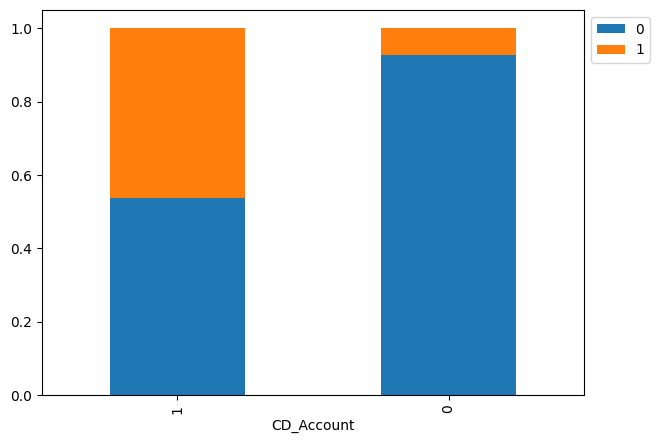

In [37]:
stacked_barplot(plcData,"CD_Account", "Personal_Loan")

##### Observations
* Customers with a CD Account are more likely to take out a loan than without a CD account.

#### Personal_Loan and Online Banking

Personal_Loan     0    1   All
Online                        
All            4520  480  5000
1              2693  291  2984
0              1827  189  2016
------------------------------------------------------------------------------------------------------------------------


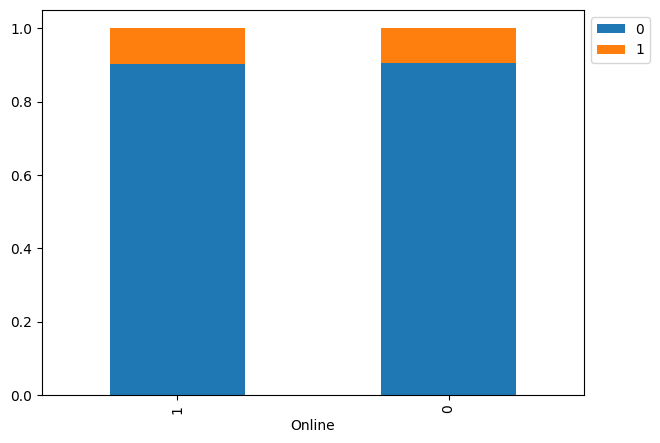

In [38]:
stacked_barplot(plcData,"Online", "Personal_Loan")

##### Observations
* Online banking appears to have no effect on whether or not a person will take out a personal loan.

#### Personal_Loan and Credit Card with other bank

Personal_Loan     0    1   All
CreditCard                    
All            4520  480  5000
0              3193  337  3530
1              1327  143  1470
------------------------------------------------------------------------------------------------------------------------


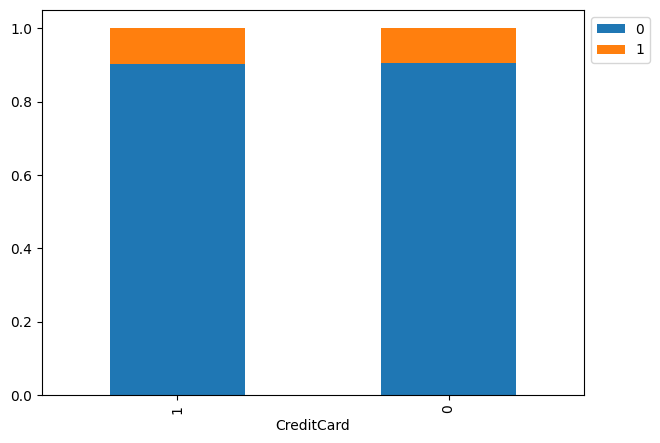

In [39]:
stacked_barplot(plcData,"CreditCard", "Personal_Loan")

##### Observations
* Credit card appears to have no effect on whether or not a person will take out a personal loan.

#### Distribution of Personal_Loan and Age

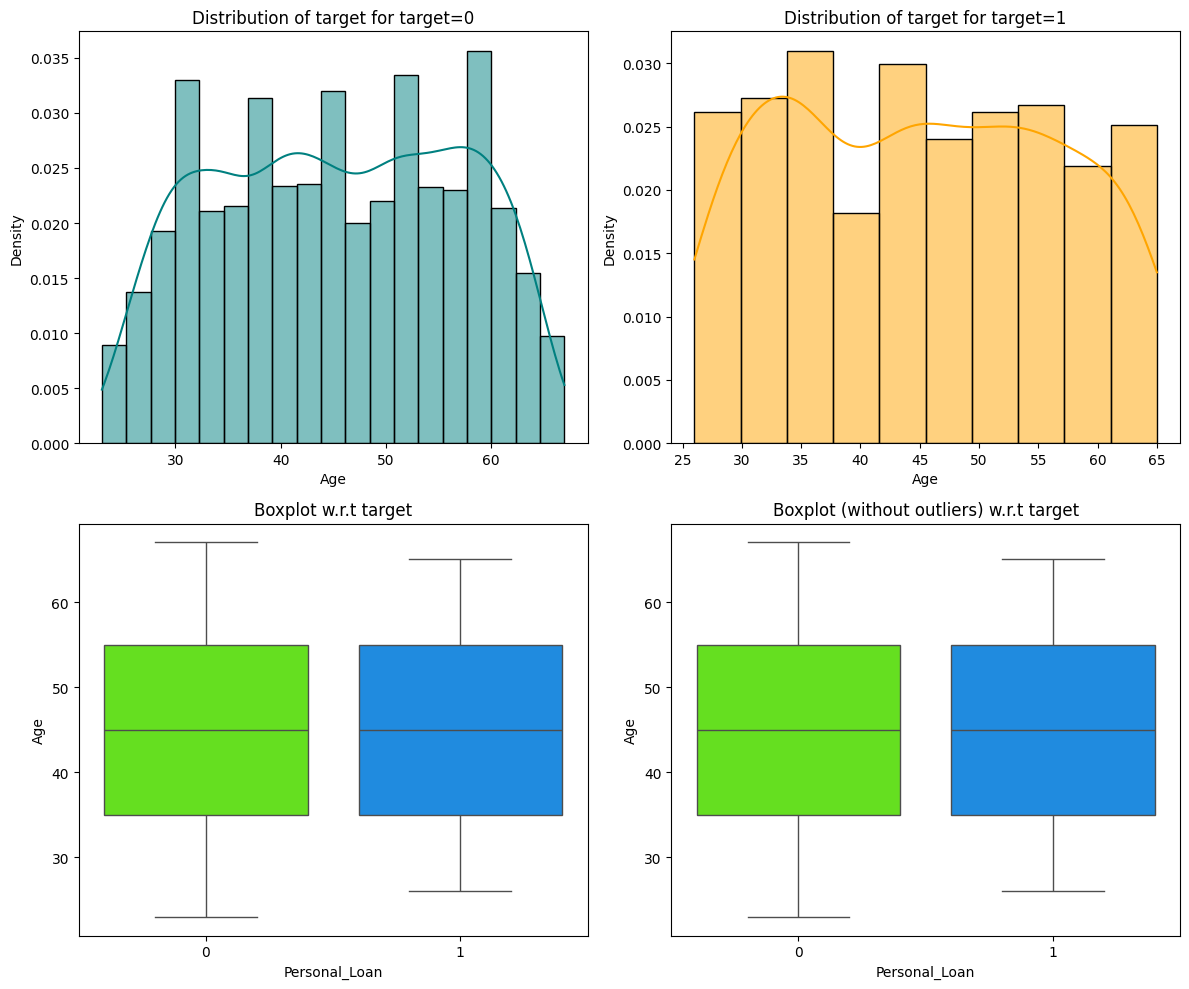

In [40]:
distribution_plot_wrt_target(plcData, "Age", "Personal_Loan")

##### Observations
* Most personal loan customers are between the ages of 30 and 60 with a slight drop off from 30 to 60.
* Customer under 30 and over 60 are less likely to take out a personal loan.

### **Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
<br>The mortgage attribute is highly skewed to the right as most people DO NOT have a mortgage. Because of the skew there are many outliers which represent people who have mortgages.

1. How many customers have credit cards?
<br>1,470
<br>This does not include customers with credit cards from AllLife Bank as there is no data for this.

1. What are the attributes that have a strong correlation with the target attribute (personal loan)?

  The following features have a positive correlation to taking out a personal loan.

  * Income
  * CCAvg
  * CD Account

1. How does a customer's interest in purchasing a loan vary with their age?

Between the ages of 30 and 60 are the prime times to purchase a loan with 30 being slightly better. Customers under 30 and over 60 are less likely to purchase a loan.

1. How does a customer's interest in purchasing a loan vary with their education?

Undergraduates are the least likely to purchase a loan. Advanced/Professional are the most likely followed closely by graduates. The more education the more likely you are to purchase a personal loan.

## Data Preprocessing

### Preparing Data For Modeling

#### Feature engineering (if needed)
* Not needed in my opinion

#### Outlier detection and treatment (if needed)
* Treat any negative experience by changing it to zero.

In [41]:
plcData.loc[plcData['Experience'] < 0, 'Experience'] = 0

In [42]:
#Test that there are no longer negatives in experience.
assert (plcData['Experience'] >= 0).all(), "There are negative values in the 'Experience' column."
# If the assertion passes, it means there are no negative values
print("All values in 'Experience' column are non-negative.")

All values in 'Experience' column are non-negative.


#### Preparing data for modeling
* Break more continuous values into categories.

##### Treat Continuous Data
**This caused issues with Recall when building the decision tree models so it is currently turned off in the Constants section at the top of this document**

|Mortgage in Thousands|New Value|
|-|-|
|0|0|
|1 to 99|1|
|100 to 299|2|
|200 to 499|3|
|500 to 699|4|
|700+|5|

In [43]:
#Mortgage
if TREAT_CONTINUOUS_DATA== True:
  conditions = [
      (plcData['Mortgage'] == 0),
      (plcData['Mortgage'] <= 99),
      (plcData['Mortgage'] <= 299),
      (plcData['Mortgage'] <= 499),
      (plcData['Mortgage'] <= 699),
      (plcData['Mortgage'] >= 700)
  ]

  choices = [0, 1, 2, 3, 4, 5]

  plcData['Mortgage'] = np.select(conditions, choices, default=0)


In [44]:
if TREAT_CONTINUOUS_DATA== True:
  #Test
  assert (plcData['Mortgage'] <= 5).all(), "Bad values in 'Mortgage' column after update."
  # Assert passes
  print("All values in 'Mortgage' column good.")

|CCAvg|New Value|
|-|-|
|0 to 699|1|
|700 to 1499|2|
|1500 to 2499|3|
|2500 to 9999|4|
|10000+|5|


In [45]:
#CCAvg
if TREAT_CONTINUOUS_DATA== True:
  conditions = [
      (plcData['CCAvg'] <= 699),
      (plcData['CCAvg'] <= 1499),
      (plcData['CCAvg'] <= 2499),
      (plcData['CCAvg'] <= 9999),
      (plcData['CCAvg'] >= 10000)
  ]

  choices = [1, 2, 3, 4, 5]

  plcData['CCAvg'] = np.select(conditions, choices, default=0)


In [46]:
if TREAT_CONTINUOUS_DATA== True:
  #Test
  assert (plcData['CCAvg'] <= 5).all(), "Bad values in 'CCAvg' column after update."
  # Assert passes
  print("All values in 'CCAvg' column good.")


|Income|New Value|
|-|-|
|0 to 49999|1|
|50000 to 74999|2|
|75000 to 99999|3|
|10000+|4|


In [47]:
#Income
if TREAT_CONTINUOUS_DATA== True:
  conditions = [
      (plcData['Income'] <= 49999),
      (plcData['Income'] <= 74999),
      (plcData['Income'] <= 99999),
      (plcData['Income'] >= 100000)
  ]

  choices = [1, 2, 3, 4]

  plcData['Income'] = np.select(conditions, choices, default=0)


In [48]:
if TREAT_CONTINUOUS_DATA== True:
  #Test
  assert (plcData['Income'] <= 4).all(), "Bad values in 'Income' column after update."
  # Assert passes
  print("All values in 'Income' column good.")


|Age|New Value|
|-|-|
|0 to 29|1|
|30 to 39|2|
|40 to 49|3|
|50 to 59|4|
|60+|5|


In [49]:
#Age
if TREAT_CONTINUOUS_DATA== True:
  conditions = [
      (plcData['Age'] <= 29),
      (plcData['Age'] <= 39),
      (plcData['Age'] <= 49),
      (plcData['Age'] <= 59),
      (plcData['Age'] >= 60)
  ]

  choices = [1, 2, 3, 4, 5]

  plcData['Age'] = np.select(conditions, choices, default=0)


In [50]:
if TREAT_CONTINUOUS_DATA== True:
  #Test
  assert (plcData['Age'] <= 5).all(), "Bad values in 'Age' column after update."
  # Assert passes
  print("All values in 'Age' column good.")


|Experience|New Value|
|-|-|
|0 to 4|1|
|5 to 14|2|
|15 to 24|3|
|25 to 34|4|
|35+|5|

In [51]:
#Experience
if TREAT_CONTINUOUS_DATA== True:
  conditions = [
      (plcData['Experience'] <= 4),
      (plcData['Experience'] <= 14),
      (plcData['Experience'] <= 24),
      (plcData['Experience'] <= 34),
      (plcData['Experience'] >= 35)
  ]

  choices = [1, 2, 3, 4, 5]

  plcData['Experience'] = np.select(conditions, choices, default=0)


In [52]:
if TREAT_CONTINUOUS_DATA== True:
  #Test
  assert (plcData['Experience'] <= 5).all(), "Bad values in 'Experience' column after update."
  # Assert passes
  print("All values in 'Experience' column good.")

#### Missing value treatment  
* There are no missing values.


## Model Building

### Model Evaluation Criterion

* The worst case scenario is if a customer is not offered a personal loan and would have taken it had it been offered.
* This is a Type II error and would result in a missed opportunity.
* To minimize these False Negative we need to prioritize **recall** above other model evaluation metrics.



### Model Building

#### Split the Data
We need a training and test set.

In [53]:
# Drop ID and ZIPCode
#plcData.drop("ID" , axis=1, inplace=True)
#plcData.drop("ZIPCode" , axis=1, inplace=True)

plcData_copy = plcData.copy(deep=True)
X = plcData_copy.drop("Personal_Loan" , axis=1)
y = plcData_copy.pop("Personal_Loan")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

#### Build the Decision Tree #1

In [54]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

### Model Performance Improvement

#### Scoring the Decision Tree

In [55]:
print("Accuracy on training set : ",dTree.score(X_train, y_train))
print("Accuracy on test set : ",dTree.score(X_test, y_test))

Accuracy on training set :  1.0
Accuracy on test set :  0.9793333333333333


##### Observations
* I think the accuracy on the test set is good, but we want to look at recall or the number of false negatives.

#### Confusion Matrix

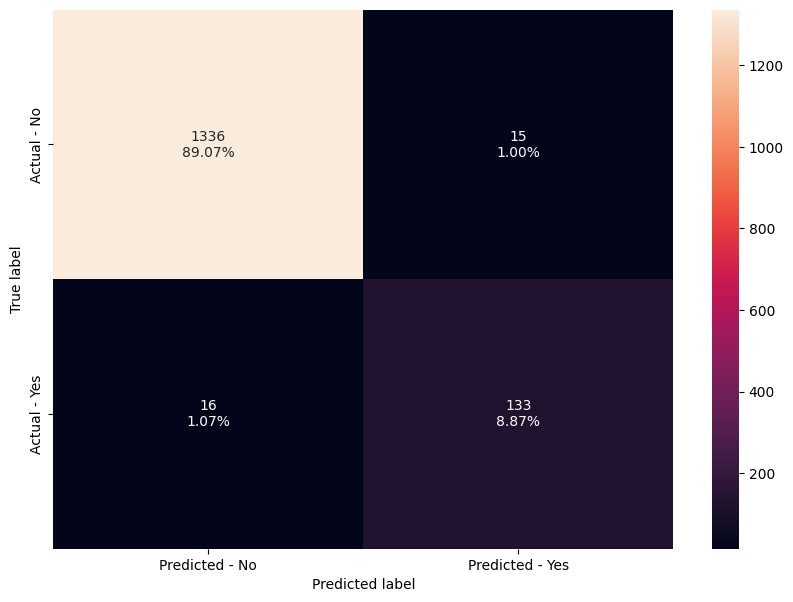

In [56]:
make_confusion_matrix(dTree,y_test)

##### Recall

In [57]:
# Recall on train and test
get_recall_score(dTree)

Recall on training set :  1.0
Recall on test set :  0.8926174496644296


##### Visualize the Decision Tree

['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']


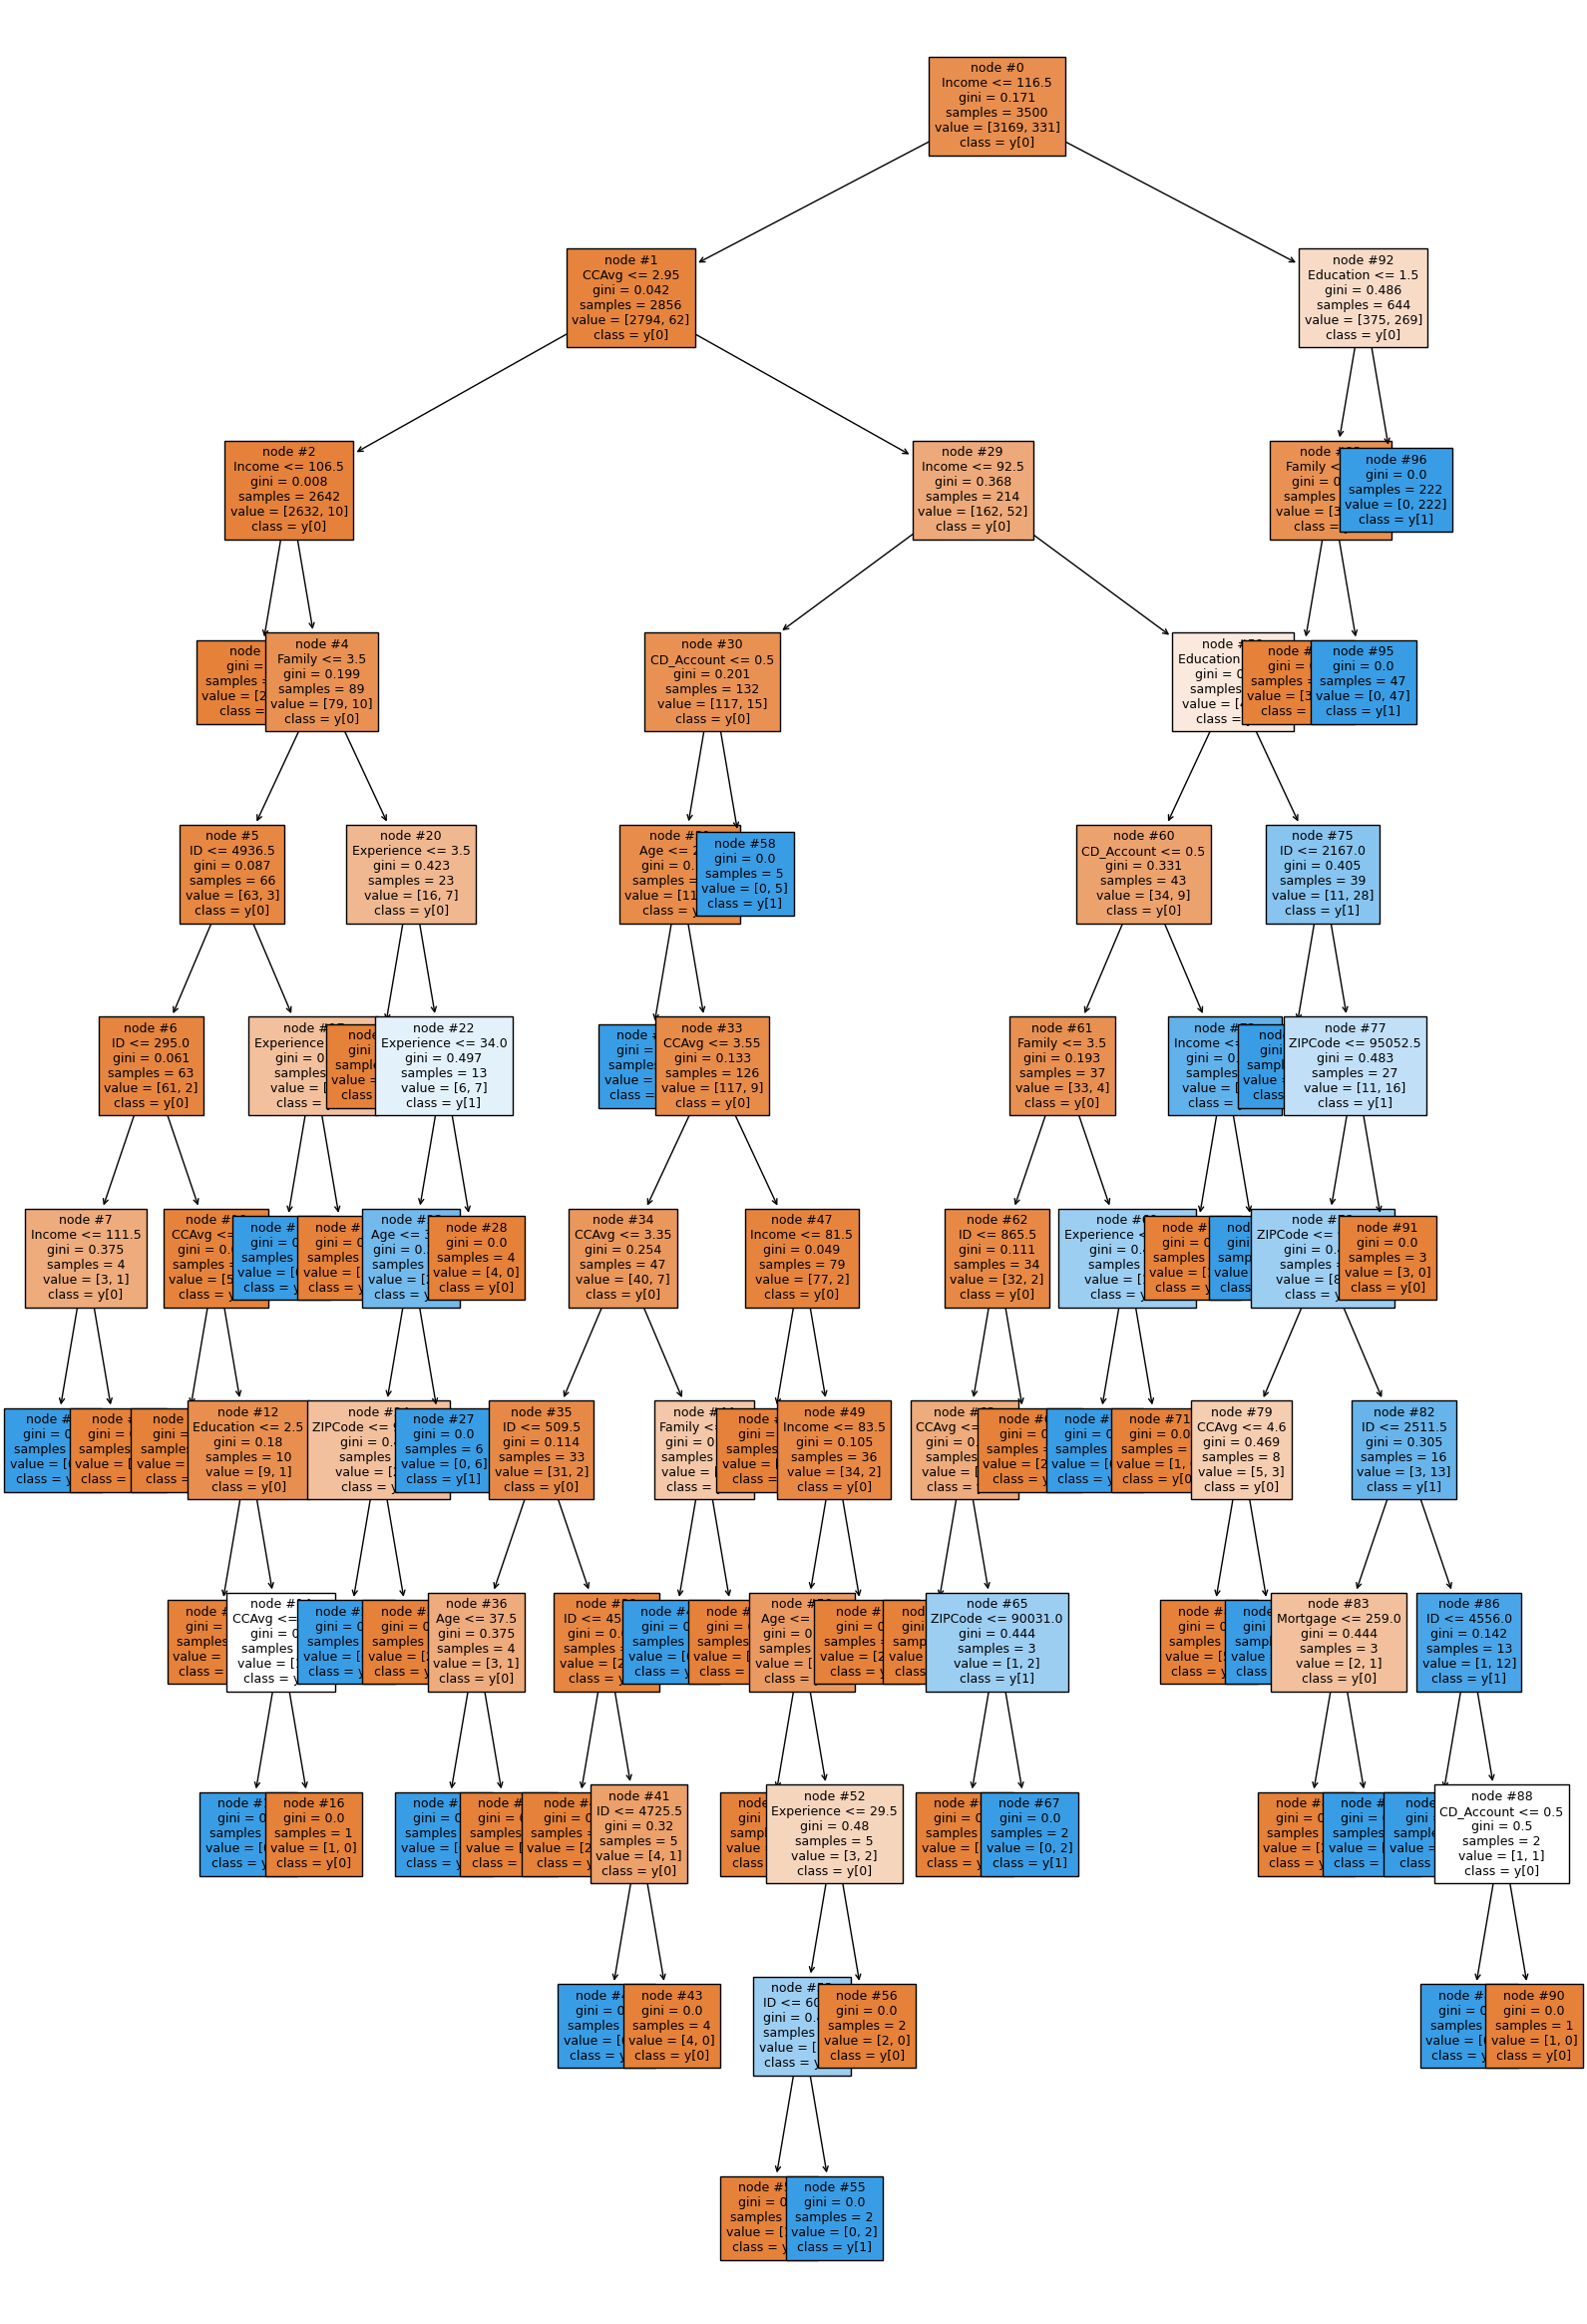

In [58]:
#print the feature names
feature_names = list(X.columns)
print(feature_names)
#visualize the tree
plt.figure(figsize=(20,30))
tree.plot_tree(dTree,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

###### Observations
* Let's try to prune the tree to increase Recall.

#### Gini Importance

In [59]:
# importance of features in the tree building ( The importance of a feature is computed as the
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                         Imp
Education           0.402286
Income              0.304042
Family              0.157297
CCAvg               0.053165
CD_Account          0.024352
ID                  0.017656
Experience          0.017286
ZIPCode             0.011810
Age                 0.009880
Mortgage            0.002224
Securities_Account  0.000000
Online              0.000000
CreditCard          0.000000


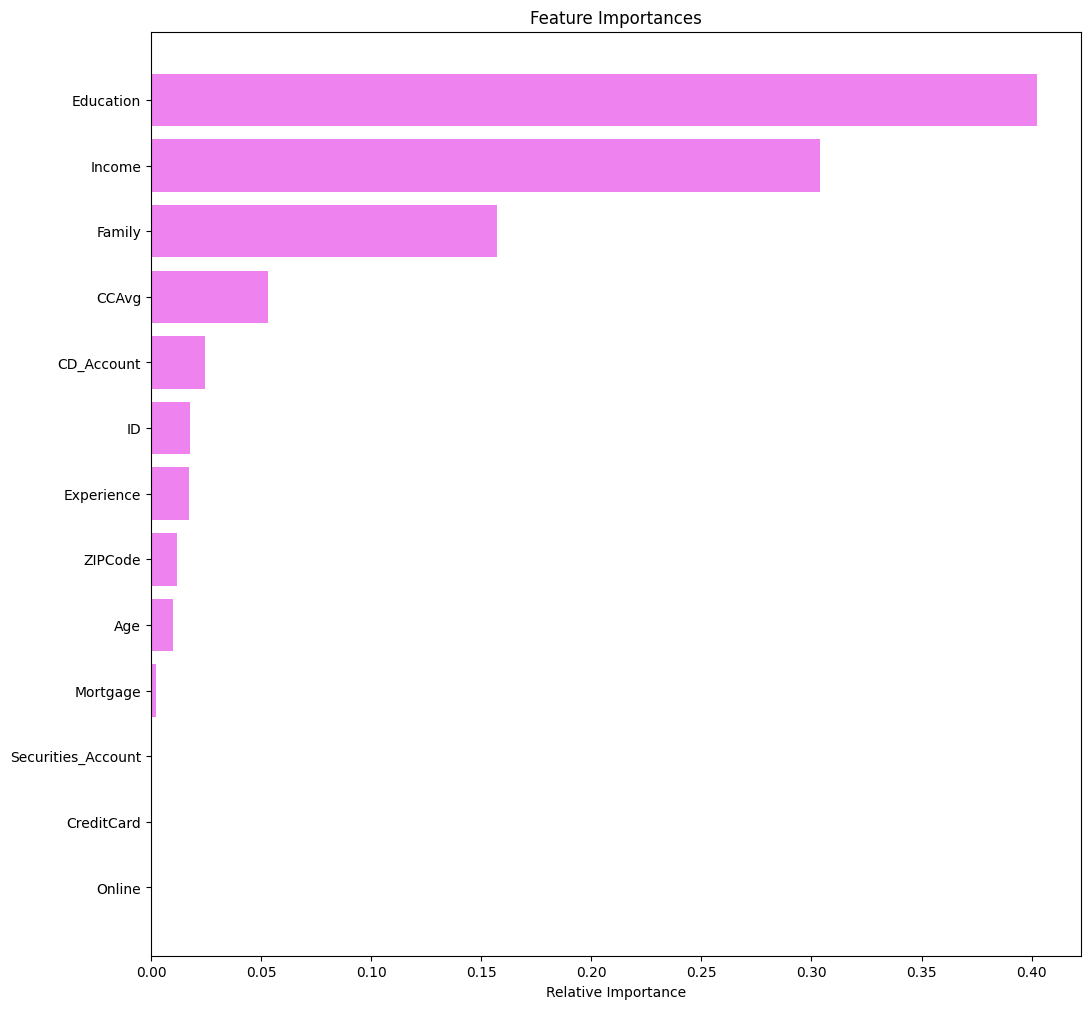

In [60]:
importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Reduce Overfitting

##### Build the Decision Tree #2

In [61]:
# Create a new classifier with a max depth of 3
dTree1 = DecisionTreeClassifier(criterion = 'gini',max_depth=3,random_state=1)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

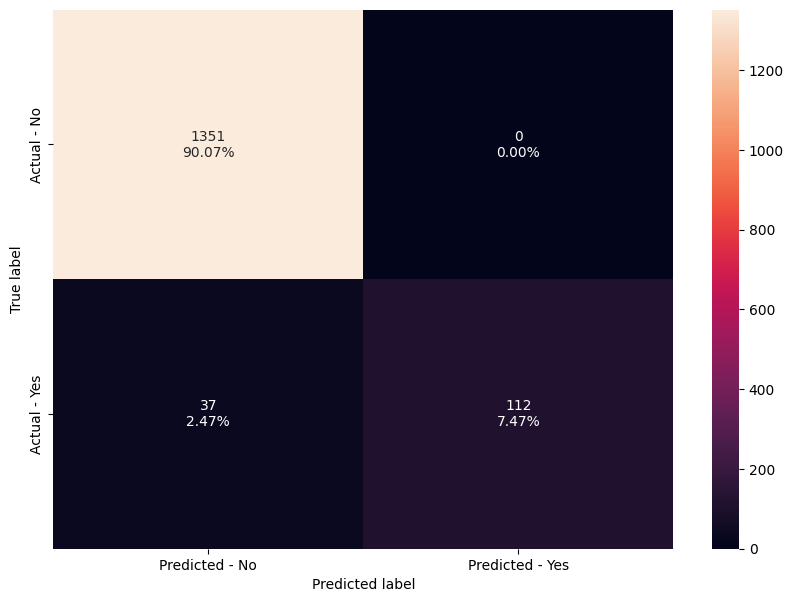

In [62]:
#Remake the confusion matrix
make_confusion_matrix(dTree1, y_test)

In [63]:
# Get recall
# Recall on train and test
get_recall_score(dTree)

Recall on training set :  1.0
Recall on test set :  0.8926174496644296


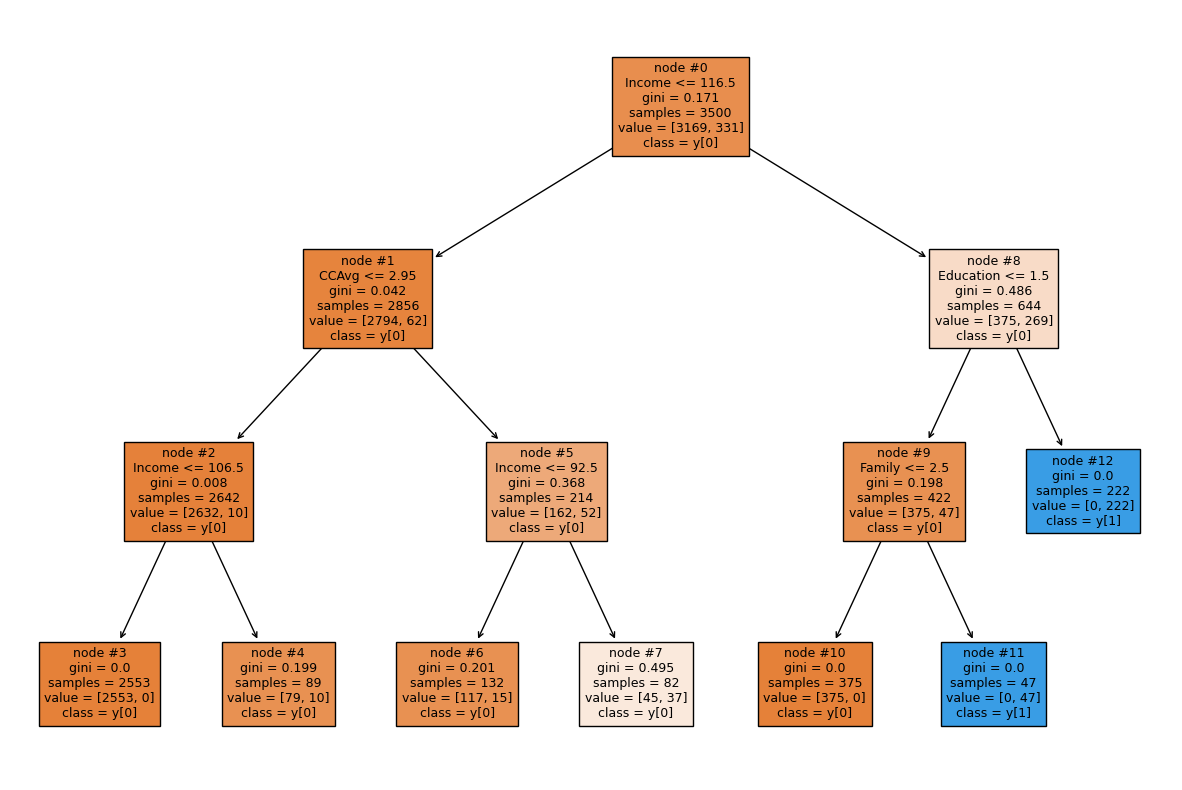

In [64]:
#Visualize the tree again
plt.figure(figsize=(15,10))

tree.plot_tree(dTree1,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [65]:
# Show the text
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree1,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2553.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- weights: [79.00, 10.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 92.50
|   |   |   |--- weights: [117.00, 15.00] class: 0
|   |   |--- Income >  92.50
|   |   |   |--- weights: [45.00, 37.00] class: 0
|--- Income >  116.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [375.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [0.00, 47.00] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [0.00, 222.00] class: 1



#### Reduce Overfitting with Hyperparameters

##### Build the Decision Tree #3

In [66]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_depth': np.arange(1,10),
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, random_state=1)

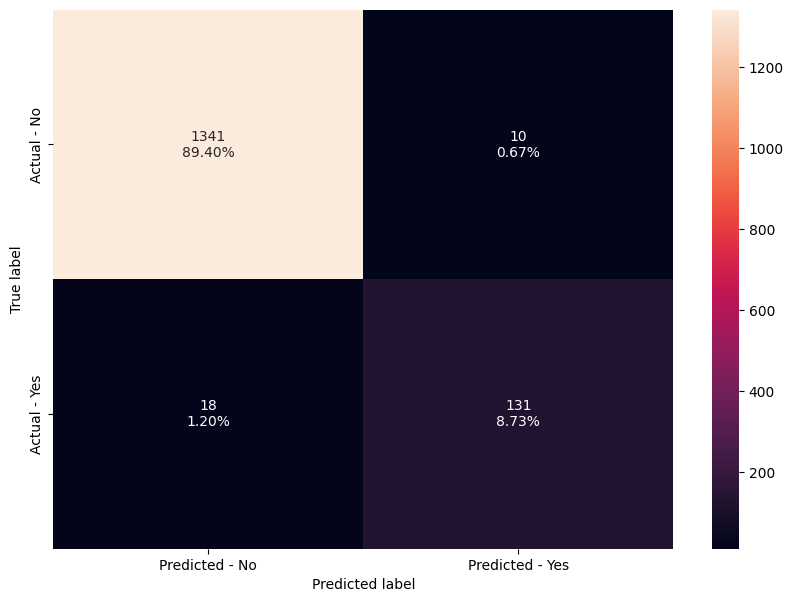

In [67]:
#Confusion Matrix
make_confusion_matrix(estimator,y_test)

In [68]:
# Accuracy on train and test
print("Accuracy on training set : ",estimator.score(X_train, y_train))
print("Accuracy on test set : ",estimator.score(X_test, y_test))
# Recall on train and test
get_recall_score(estimator)

Accuracy on training set :  0.9897142857142858
Accuracy on test set :  0.9813333333333333
Recall on training set :  0.9274924471299094
Recall on test set :  0.8791946308724832


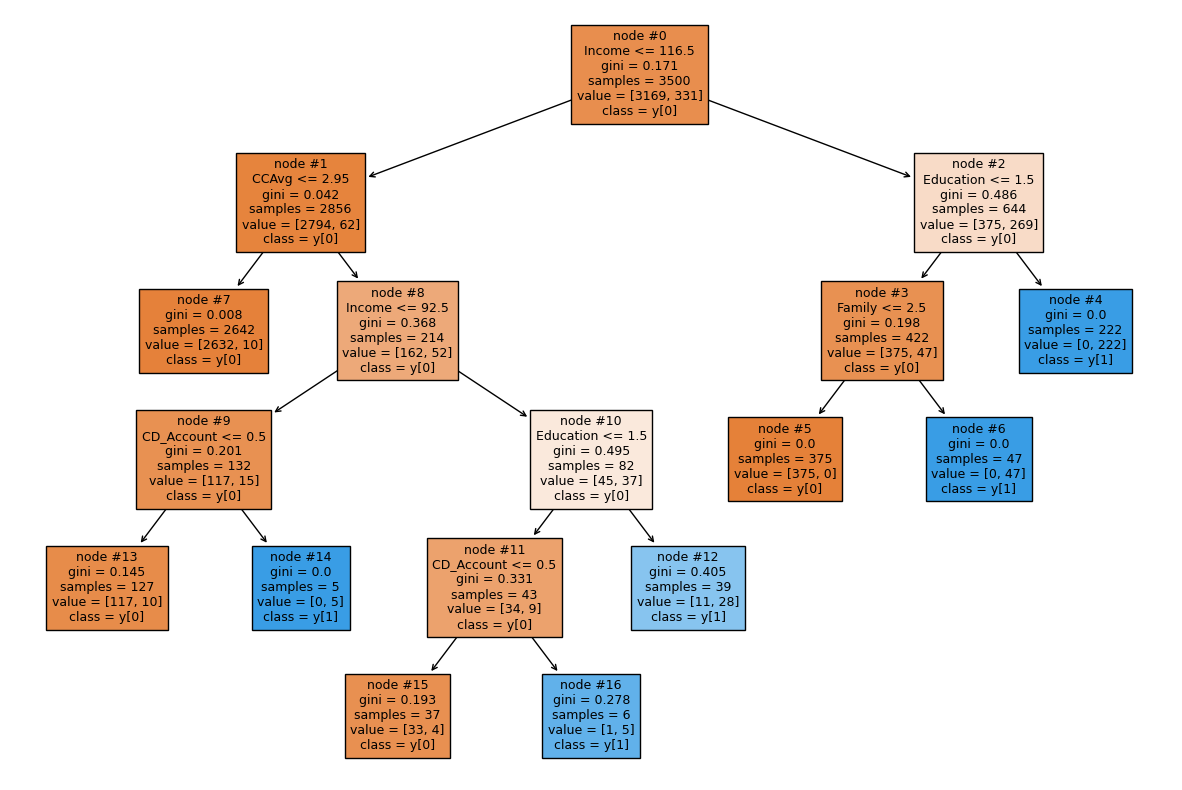

In [69]:
#Visualize the new tree
plt.figure(figsize=(15,10))

tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [70]:
# Text report showing the rules of a decision tree -

print(tree.export_text(estimator,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [2632.00, 10.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 92.50
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- weights: [117.00, 10.00] class: 0
|   |   |   |--- CD_Account >  0.50
|   |   |   |   |--- weights: [0.00, 5.00] class: 1
|   |   |--- Income >  92.50
|   |   |   |--- Education <= 1.50
|   |   |   |   |--- CD_Account <= 0.50
|   |   |   |   |   |--- weights: [33.00, 4.00] class: 0
|   |   |   |   |--- CD_Account >  0.50
|   |   |   |   |   |--- weights: [1.00, 5.00] class: 1
|   |   |   |--- Education >  1.50
|   |   |   |   |--- weights: [11.00, 28.00] class: 1
|--- Income >  116.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [375.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [0.00, 47.00] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [0.00, 222.00] class: 1



## Model Comparison and Final Model Selection

**Decision Tree #3** would be the best fit.

hyper-parameters of:
* max_depth=5
* max_leaf_nodes=10,
* min_impurity_decrease=0.001
* random_state=1

Although all the models performed well I think the recall on the training and test set for Decision Tree #3 allows for a generalized model which should produce a Type II error percentage of about 1.2% on any new data which is generated.

So roughly 1 out of 100 people we do not recommend for a personal loan would have taken the personal loan had we offered it.



## Actionable Insights and Business Recommendations


### Key Recommendations

#### 1. Targeted Marketing Strategies:
   * Leverage insights from Decision Tree #3 to design targeted marketing campaigns for personal loan.
   * Focus on customers with higher education, income, and family size, as these factors positively influence personal loan acceptance.

#### 2. Customer Segmentation:
   * Implement customer segmentation based on key features identified in the decision tree. Consider additional analysis using K-Means Clustering to segment customers as the data matures.
   * Once you have identified customer segments AllLife can tailor marketing messages and product offerings to different customer segments to remain relevant and enhance engagement.

#### 3. Collaboration with Sales Teams:
   * Foster collaboration between marketing and sales teams to align efforts in targeting potential loan customers.
   * Share insights from the decision tree model to optimize customer interactions and improve conversion rates.

#### 4. Continuous Monitoring and Model Refinement:
   * Regularly monitor the performance of the decision tree model based on the latest data to ensure the model remains effective.



___